# T-SNE

Paper and references: [Visualizing Data using t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

T-distibuted Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. The technique can be implemented via Barnes-Hut approximations, allowing it to be applied on large real-world datasets.

In this notebook, we will implement t-SNE from scratch using Python and NumPy. We will then compare our implementation with the one provided by scikit-learn.


### Motivation

The primary motivation behind t-SNE is to visualize high-dimensional data in two or three dimensions while preserving the local structure of the data. Traditional techniques like Principal Component Analysis (PCA) tend to focus on preserving global structures, which can overshadow small but meaningful patterns in the data. t-SNE, on the other hand, efficiently maps similar points closer together in the lower-dimensional space, helping researchers and data scientists gain insights into clustered relationships that may not be apparent directly.

### Intuition

t-SNE works by modeling pairwise similarities between data points in both high-dimensional and low-dimensional spaces. It aims to minimize the divergence between these two similarity distributions, effectively retaining the local structure of the dataset in the reduced dimension.

It works by computing pairwise similarity between all points in higher and lower dimension, and then minimizing the Kullback-Leibler divergence between the two distributions. The algorithm is iterative and uses gradient descent to update the positions of points in the lower-dimensional space.

A Pairwise Similarity is a measure of how similar two points are to each other. In the high-dimensional space, the similarity is computed using a Gaussian distribution, while in the low-dimensional space, a t-distribution is used. The t-distribution is chosen for its heavier tails, which is more sensitive to moderate-sized dissimilarities between points. This causes points in lower dimensions to be more spread out, making it easier to visualize clusters. 


#### t-SNE High-Level Process

1. **Compute Pairwise Similarities in High Dimension**: Gaussian distribution is used for measuring similarity between points.
2. **Compute Pairwise Similarities in Low Dimension**: The t-distribution is utilized to compute similarities.
3. **Minimize Divergence**: Use Kullback-Leibler divergence to align the two similarity distributions.

This process allows t-SNE to provide intuitive visualizations where clusters in the original data can be identified and interpreted visually.

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

### Normal Distribution

Normal Distribution Function Documentation
Mathematical Formula
The normal (Gaussian) distribution is defined by:

$f(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

where:

$\mu$ is the mean
$\sigma$ is the standard deviation
$e$ is Euler's number
$\pi$ is pi

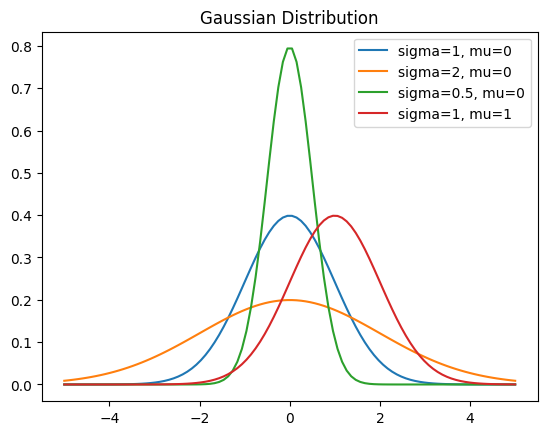

In [2]:
def normal_dist(X, sigma=1, mu=0):
    '''
    Gaussian or normal distribution function

    Parameters:
    X (np.array): input data
    sigma (float): standard deviation, default 1
    mu (float): mean, default 0
    '''

    return (1 / (sigma * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((X - mu) / sigma) ** 2)


X = np.linspace(-5, 5, 100)
y1 = normal_dist(X)
y2 = normal_dist(X, sigma=2)
y3 = normal_dist(X, sigma=0.5)
y4 = normal_dist(X, mu=1)

sns.lineplot(x=X, y=y1, label='sigma=1, mu=0')
sns.lineplot(x=X, y=y2, label='sigma=2, mu=0')
sns.lineplot(x=X, y=y3, label='sigma=0.5, mu=0')
sns.lineplot(x=X, y=y4, label='sigma=1, mu=1')

plt.title('Gaussian Distribution')
plt.show()

#### T-distibution

The Student's t-distribution probability density function implemented in t_dist is defined as:

$f(x|\nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\sqrt{\nu\pi},\Gamma(\frac{\nu}{2})} \left(1 + \frac{x^2}{\nu}\right)^{-\frac{\nu + 1}{2}}$

where:

$\nu$ is the degrees of freedom (df)
$\Gamma$ is the gamma function
$x$ is the input value
The location parameter $\mu$ shifts the distribution horizontally
The scale parameter $\sigma$ stretches/shrinks the distribution
For $\nu \to \infty$, the t-distribution approaches a normal distribution. Smaller values of $\nu$ result in heavier tails, as shown in the plot where df=1 has much fatter tails than df=10.

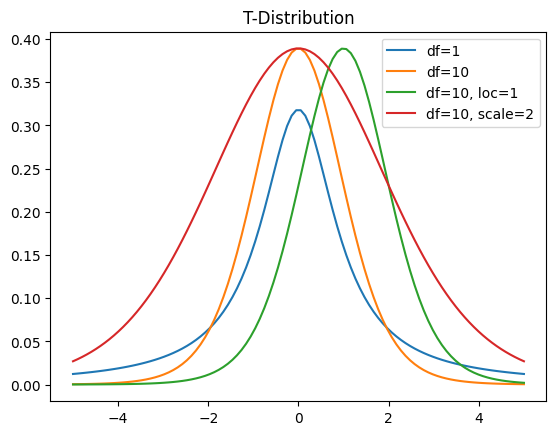

In [3]:
from scipy.special import gamma

# gamma is the gamma function which is an extension of the factorial function to real and complex numbers
# gamma(n) = (n-1)!, where n is a positive integer
# gamma(z) = integral(0, inf, t^(z-1) * e^(-t) dt), where z is a complex number

def t_dist(X, df, loc = 0, scale = 1):
    """
    Calculate Student's t-distribution probability density.

    Args:
        X: Input values
        df: Degrees of freedom
        loc: Location parameter (mean)
        scale: Scale parameter (standard deviation)

    Returns:
        Array of probability densities

    Raises:
        ValueError: If df <= 0 or scale <= 0
    """
    # Calculate coefficient term
    coef = gamma((df + 1) / 2) / (np.sqrt(df * np.pi) * gamma(df / 2))

    # Calculate standardized values
    z = (X - loc) / scale

    # Calculate density
    density = coef * (1 + z**2 / df)**(-(df + 1) / 2)

    return density


X = np.linspace(-5, 5, 100)
y1 = t_dist(X, df=1)
y2 = t_dist(X, df=10)
y3 = t_dist(X, df=10, loc=1)
y4 = t_dist(X, df=10, scale=2)

sns.lineplot(x=X, y=y1, label='df=1')
sns.lineplot(x=X, y=y2, label='df=10')
sns.lineplot(x=X, y=y3, label='df=10, loc=1')
sns.lineplot(x=X, y=y4, label='df=10, scale=2')

plt.title('T-Distribution')
plt.show()

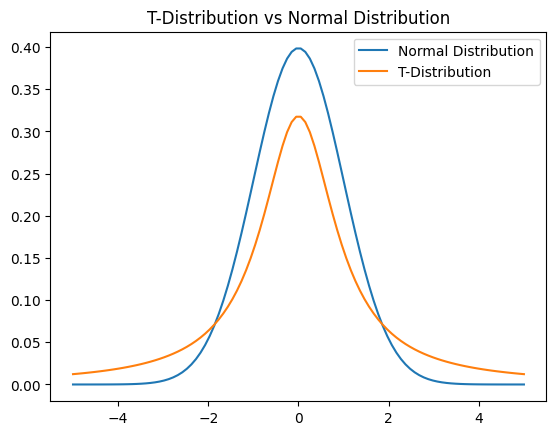

In [4]:
### T-Distribution vs Normal Distribution

X = np.linspace(-5, 5, 100)
y1 = normal_dist(X)
y2 = t_dist(X, df=1)

sns.lineplot(x=X, y=y1, label='Normal Distribution')
sns.lineplot(x=X, y=y2, label='T-Distribution')

plt.title('T-Distribution vs Normal Distribution')
plt.show()

As you can see, t-distribution has heavier tails compared to the normal distribution. This property makes it more sensitive to moderate-sized dissimilarities between points, which is why it is used in t-SNE to model pairwise similarities in the low-dimensional space.

### Pairwise Similarity

To understand pairwise similarity in the context of t-SNE, we need to delve into how we estimate how similar or dissimilar two data points are in the high-dimensional space. In t-SNE, this similarity is based on the probability distribution over pairs of data points.

**High-Dimensional Similarity (Using Gaussian Distribution):**

For each pair of data points $ x_i $ and $ x_j $, we define the conditional probability $ p_{j|i} $ as the probability that $ x_j $ would be picked as a neighbor of $ x_i $ if neighbors were picked in proportion to their probability density under a Gaussian centered at $ x_i $. Mathematically, this is given by:

$
p_{j|i} = \frac{\exp(-\|x_i - x_j\|^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\|x_i - x_k\|^2 / 2\sigma_i^2)}
$

Here, $ \sigma_i $ is a parameter that determines the bandwidth of the Gaussian kernel for each data point $ x_i $.

The joint probability distribution $ p_{ij} $ is symmetrized as follows:

$
p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}
$

where $ n $ is the total number of data points.

### Example

Let's consider a simple dataset with four data points in 2D space:

| Point | feature 1 | feature 2 |
|-------|--------|--------|
| 1     | 1.0    | 2.0    |
| 2     | 1.1    | 2.1    |
| 3     | 4.0    | 4.0    |
| 4     | 4.1    | 4.1    |

To compute pairwise similarities, follow these steps:

1.  Compute the squared Euclidean distance between each pair of points.

    - $ \|x_1 - x_2\|^2 = (1.0 - 1.1)^2 + (2.0 - 2.1)^2 = 0.02 $
    - $ \|x_1 - x_3\|^2 = (1.0 - 4.0)^2 + (2.0 - 4.0)^2 = 13.0 $
    - $ \|x_1 - x_4\|^2 = (1.0 - 4.1)^2 + (2.0 - 4.1)^2 = 14.02 $
    - $ \|x_2 - x_3\|^2 = (1.1 - 4.0)^2 + (2.1 - 4.0)^2 = 12.02 $
    - $ \|x_2 - x_4\|^2 = (1.1 - 4.1)^2 + (2.1 - 4.1)^2 = 13.0 $
    - $ \|x_3 - x_4\|^2 = (4.0 - 4.1)^2 + (4.0 - 4.1)^2 = 0.02 $

2.  Use a Gaussian kernel with a bandwidth $ \sigma $ to convert distances to probabilities
    using the formula $ p_{j|i} = \exp(-\|x_i - x_j\|^2 / 2\sigma^2) $.

    - $ p_{2|1} = \exp(-0.02 / 2\sigma^2) $
    - $ p_{3|1} = \exp(-13.0 / 2\sigma^2) $
    - $ p_{4|1} = \exp(-14.02 / 2\sigma^2) $
    - $ p_{3|2} = \exp(-12.02 / 2\sigma^2) $
    - $ p_{4|2} = \exp(-13.0 / 2\sigma^2) $
    - $ p_{4|3} = \exp(-0.02 / 2\sigma^2) $

In [5]:
def pairwise_similarity_gauss(X, sigma=1.0, epsilon=1e-8):
    n = X.shape[0]

    # Compute pairwise squared Euclidean distances
    squared_dist = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=-1)
    # Compute Gaussian kernel row-wise
    logits = -squared_dist / (2 * sigma ** 2)
    # Normalize to prevent numerical instability when exponentiating
    # logits = (n, n), max(logits, axis=1, keepdims=True) = (n,1)
    logits = logits - np.max(logits, axis=1, keepdims=True)
    # Compute P_{j|i}
    P = np.exp(logits)
    # Set diagonal to zero (self-similarity is not useful)
    np.fill_diagonal(P, 0)

    # Normalize P, divide by row sums, add epsilon to prevent division by zero
    P = P / (np.sum(P, axis=1, keepdims=True) + epsilon)

    # Symmetrize to get joint probabilities p_{ij}
    # from conditional probabilities p_{j|i} and p_{i|j}
    P = (P + P.T) / (2 * n)
    return P

X = np.array([ [1.0, 2.0], [1.1, 2.1], [4.0, 4.0], [4.1, 4.1] ])

pairwise_similarity = pairwise_similarity_gauss(X, sigma=1.0)
print("Pairwise Similarity Matrix:")
print(pairwise_similarity)

Pairwise Similarity Matrix:
[[0.00000000e+00 2.49199257e-01 3.78421284e-04 2.27417766e-04]
 [2.49199257e-01 0.00000000e+00 6.17220820e-04 3.78421284e-04]
 [3.78421284e-04 6.17220820e-04 0.00000000e+00 2.49199257e-01]
 [2.27417766e-04 3.78421284e-04 2.49199257e-01 0.00000000e+00]]


**Low-Dimensional Similarity (Using t-Distribution):**

For each pair of data points $ x_i $ and $ x_j $, we define the similarity using the t-distribution with one degree of freedom (Cauchy distribution). The similarity $ q_{ij} $ is given by:

$ q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l} (1 + \|y_k - y_l\|^2)^{-1}} $

Here, $ y_i $ and $ y_j $ are the low-dimensional representations of the high-dimensional data points $ x_i $ and $ x_j $.

The joint probability distribution $ q_{ij} $ is symmetrized as follows:

$ q_{ij} = \frac{q_{ij} + q_{ji}}{2n} $

where $ n $ is the total number of data points.

### Example

Let's consider a simple dataset with four data points in 2D space:

| Point | feature 1 | feature 2 |
|-------|-----------|-----------|
| 1     | 1.0       | 2.0       |
| 2     | 1.1       | 2.1       |
| 3     | 4.0       | 4.0       |
| 4     | 4.1       | 4.1       |

To compute pairwise similarities using the t-distribution, follow these steps:

1. Compute the squared Euclidean distance between each pair of points.

    - $ \|x_1 - x_2\|^2 = (1.0 - 1.1)^2 + (2.0 - 2.1)^2 = 0.02 $
    - $ \|x_1 - x_3\|^2 = (1.0 - 4.0)^2 + (2.0 - 4.0)^2 = 13.0 $
    - $ \|x_1 - x_4\|^2 = (1.0 - 4.1)^2 + (2.0 - 4.1)^2 = 14.02 $
    - $ \|x_2 - x_3\|^2 = (1.1 - 4.0)^2 + (2.1 - 4.0)^2 = 12.02 $
    - $ \|x_2 - x_4\|^2 = (1.1 - 4.1)^2 + (2.1 - 4.1)^2 = 13.0 $
    - $ \|x_3 - x_4\|^2 = (4.0 - 4.1)^2 + (4.0 - 4.1)^2 = 0.02 $

2. Use the t-distribution kernel to convert distances to similarities using the formula $ q_{ij} = (1 + \|x_i - x_j\|^2)^{-1} $.

    - $ q_{12} = (1 + 0.02)^{-1} $
    - $ q_{13} = (1 + 13.0)^{-1} $
    - $ q_{14} = (1 + 14.02)^{-1} $
    - $ q_{23} = (1 + 12.02)^{-1} $
    - $ q_{24} = (1 + 13.0)^{-1} $
    - $ q_{34} = (1 + 0.02)^{-1} $

3. Normalize the similarities to get the joint probabilities $ q_{ij} $.

4. Symmetrize the joint probabilities:

    - $ q_{ij} = \frac{q_{ij} + q_{ji}}{2n} $

This approach ensures that the similarities in the low-dimensional space are computed using the t-distribution, which is more suitable for t-SNE.

In [6]:
def pairwise_similarity_t_dist(X, epsilon=1e-8):
    n = X.shape[0]

    # Compute pairwise squared Euclidean distances
    squared_dist = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=-1)

    # Compute t-distribution kernel
    # t-distribution with 1 degree of freedom (Cauchy distribution)
    P = (1 + squared_dist) ** -1

    # Set diagonal to zero (self-similarity is not useful)
    np.fill_diagonal(P, 0)

    # Normalize P, divide by row sums, add epsilon to prevent division by zero
    P = P / (np.sum(P, axis=1, keepdims=True) + epsilon)

    # Symmetrize to get joint probabilities p_{ij}
    # from conditional probabilities p_{j|i} and p_{i|j}
    P = (P + P.T) / (2 * n)

    return P


X = np.array([ [1.0, 2.0], [1.1, 2.1], [4.0, 4.0], [4.1, 4.1] ])

pairwise_similarity = pairwise_similarity_t_dist(X)
print("Pairwise Similarity Matrix:")
print(pairwise_similarity)

Pairwise Similarity Matrix:
[[0.         0.21815796 0.01589437 0.01488242]
 [0.21815796 0.         0.01701293 0.01589437]
 [0.01589437 0.01701293 0.         0.21815796]
 [0.01488242 0.01589437 0.21815796 0.        ]]


### Visualizing Similarity Matrices

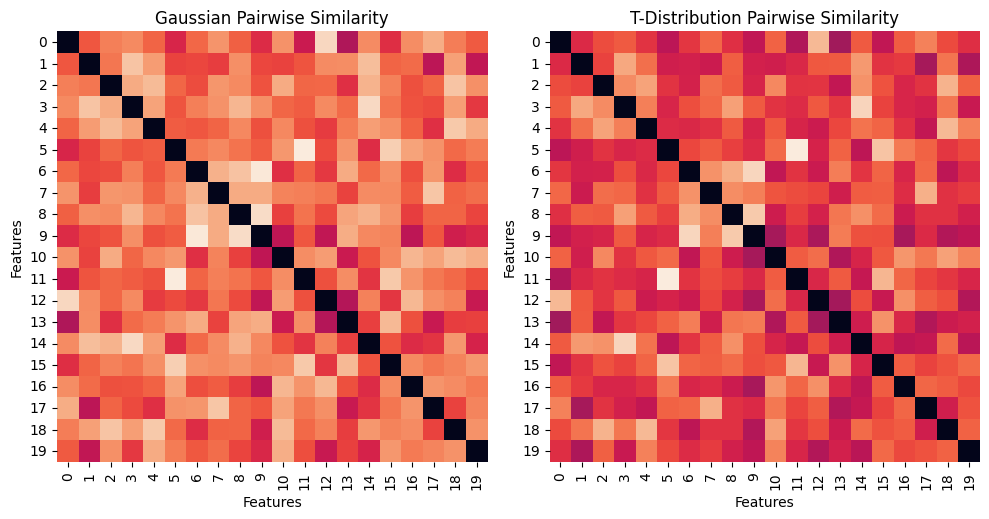

In [12]:
X = np.random.rand(20, 5)
ps_gauss = pairwise_similarity_gauss(X, sigma=1.0)
ps_t_dist = pairwise_similarity_t_dist(X)

# Create a figure with multiple subplots
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.heatmap(ps_gauss, square=True, cbar=False)
plt.title('Gaussian Pairwise Similarity')
plt.xlabel('Features')
plt.ylabel('Features')

plt.subplot(1, 2, 2)
sns.heatmap(ps_t_dist, square=True, cbar=False)
plt.title('T-Distribution Pairwise Similarity')
plt.xlabel('Features')
plt.ylabel('Features')

plt.tight_layout()
plt.show()

The left heatmap is the high-dimensional similarity matrix based on the Gaussian distribution. And the left heatmap is the low-dimensional similarity matrix based on the t-distribution. Notice how the similarity values for the low-dimensional are higher compared to the high-dimensional space. This is because the t-distribution is more sensitive to moderate-sized dissimilarities, which helps in preserving the local structure of the data.

This is the core idea behind t-SNE: preserving local structures in the data by modeling pairwise similarities using the t-distribution in the low-dimensional space.

___

### Minimizing Dissimilarity using Kullback-Leibler Divergence

We minimize the divergence between the high-dimensional similarity distribution $ P $ and the low-dimensional similarity distribution $ Q $ using the Kullback-Leibler (KL) divergence. The KL divergence is a measure of how one probability distribution diverges from a second, expected probability distribution.

KL divergence is a measure from information theory that quantifies how one probability distribution diverges from a second, expected probability distribution. In the context of t-SNE, it evaluates how much the joint probability distribution $Q$ in the low-dimensional space diverges from the joint probability distribution $P$ in the high-dimensional space. Minimizing this divergence ensures that the relationships between points are preserved as much as possible when mapping to a lower-dimensional space.

The formula for the KL divergence between two probability distributions $P$ and $Q$ is given by:

$$ D_{KL}(P \parallel Q) = \sum_{i} \sum_{j} p_{ij} \log \frac{p_{ij}}{q_{ij}} $$

where 

$ P_{ij} = \frac{p_{i|j} + p_{j|i}}{2n} $, $p_{i|j}$ is the conditional probability tht $x_j$ would pick $x_i$ as its neighbor. They are averaged over all pairs of points because we symmetrize the probabilities.

$ q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l} (1 + \|y_k - y_l\|^2)^{-1}} $, $y_i$ and $y_j$ are the low-dimensional representations of the high-dimensional data points $x_i$ and $x_j$.

This divergence gives us an objective function $ C = D_{KL}(P \parallel Q) $ that we aim to minimize using gradient descent.

#### Gradient of the KL Divergence

To minimize the KL divergence, we need to compute the gradient of the objective function $ C $ with respect to the low-dimensional data points $ Y = \{y_1, y_2, \ldots, y_n\} $. To simplify we compute the gradient of the KL divergence with respect to a single point $ y_i $ first and then generalize it to all points.

$ C = D_{KL}(P \parallel Q) = \sum_{i} \sum_{j} p_{ij} \log \frac{p_{ij}}{q_{ij}} $
$ = \sum_{i} \sum_{j} p_{ij} \log p_{ij} - p_{ij} \log q_{ij} $

The left term is constant with respect to $ y_i $, so we only need to compute the gradient of the right term.

$ \frac{\partial C}{\partial y_i} = \frac{\partial}{\partial y_i} \left( - \sum_{i} \sum_{j} p_{ij} \log q_{ij} \right) $

Note, here $ \sum_i $ is removed as we are computing the gradient with respect to a single point $ y_i $.

___

To simplify the calculations, let's define 2 auxiliary variables:

$ d_{ij} = \| yi - yj \| \text{ and } Z = \sum_{k \neq l} (1 + d_{kl}^2)^{-1} $

So that

$ q_{ij} = \frac{(1 + d_{ij}^2)^{-1}}{Z} $

Now when $ y_i $ changes, the only 2 values which update are $ d_{ij} $ and $ d_{ji} $.

Using chain rule, we can write the gradient as:

$ \frac{\partial C}{\partial y_i} = \frac{\partial C}{\partial d_{ij}} \frac{\partial d_{ij}}{\partial y_i} + \frac{\partial C}{\partial d_{ji}} \frac{\partial d_{ji}}{\partial y_i} $

Since $ d_{ij} $ and $ d_{ji} $ are symmetric as it is a L2 norm / Euclidean distance, we can simplify the above equation as:

$ \frac{\partial C}{\partial y_i} = 2 \sum_{j} \left( \frac{\partial C}{\partial d_{ij}} \frac{\partial d_{ij}}{\partial y_i} \right) $

___

$ d_{ij} = \| y_i - y_j \| = \sqrt{(y_i1 - y_j1)^2 + (y_i2 - y_j2)^2 + \ldots + (y_in - y_jn)^2} $
$ = \sqrt{\sum (y_i - y_j)^2} $

Differentiate with respect to $ y_i $:

$ \frac{\partial d_{ij}}{\partial y_i} = \frac{\partial}{\partial y_i} \sqrt{\sum (y_i - y_j)^2} $

Use the chain rule

$ \frac{\partial d_{ij}}{\partial y_i} $
$ = \frac{1}{2} \frac{1}{\sqrt{\sum (y_i - y_j)^2}} \cdot 2 (y_i - y_j) $
$ = \frac{y_i - y_j}{d_{ij}} $

___

$ \frac{\partial C}{\partial d_{ij}} = \frac{\partial}{\partial d_{ij}} \left( - \sum_{i} \sum_{j} p_{ij} \log q_{ij} \right) $
$ = - \sum_{j} p_{ij} \frac{\partial}{\partial d_{ij}} \log q_{ij} $

Since for all values where $ k = l $, the term $ p_{kl} = 0 $, we can simplify the above equation as:

$ \frac{\partial C}{\partial d_{ij}} = - \sum_{k \neq l} p_{kl} \frac{\partial}{\partial d_{ij}} \log q_{kl} $

$ = - \sum_{k \neq l} p_{kl} \frac{\partial}{\partial d_{ij}} \log \left( q_{kl} \cdot \frac{Z}{Z} \right) $

$ = - \sum_{k \neq l} p_{kl} \frac{\partial}{\partial d_{ij}} \left( \log {q_{kl} Z} - \log Z \right) $

$ = - \sum_{k \neq l} p_{kl} \left( \frac{1}{q_{kl} Z} \frac{\partial}{\partial d_{ij}} q_{kl} Z - \frac{1}{Z} \frac{\partial Z}{\partial d_{ij}} \right) $

Substituting $ q_{ij} = \frac{(1 + d_{ij}^2)^{-1}}{Z} $ and $ Z = \sum_{k \neq l} (1 + d_{kl}^2)^{-1} $ into the equation, we get:

$ \frac{\partial C}{\partial d_{ij}} = - \sum_{k \neq l} p_{kl} \left( \frac{1}{q_{kl} Z} \frac{\partial}{\partial d_{ij}} {(1 + d_{kl}^2)^{-1}} - \frac{1}{Z} \frac{\partial}{\partial d_{ij}} ((1 + d_{kl}^2)^{-1}) \right) $

Now, Since $ \frac{\partial}{\partial d_{ij}} {(1 + d_{ij}^2)^{-1}} $ is $0$ 
when $ i = j $ because $ d_{ij} \| y_i - y_j \| $, and $ d_{ii} = \| y_i - y_i \| = 0 $.

Therefore, the left term is only non-zero when $ i \neq j $, we get:


$ = 2 \frac{p_{ij}}{q_{ij}} \frac{1}{Z} d_{ij} (1 + d_{ij}^2)^{-2} - 2 \sum_{k \neq l} p_{kl} \cdot d_{ij} \frac{(1 + d_{ij}^2)^{-2}}{Z} $

Since $ \sum_{k \neq l} p_{kl} = 1 $ as the sum of all probabilities is $1$, we can simplify the equation as:

$ \frac{\partial C}{\partial d_{ij}} $
$ = 2 \frac{p_{ij}}{q_{ij}} \frac{1}{Z} d_{ij} (1 + d_{ij}^2)^{-2} - 2 d_{ij} \frac{(1 + d_{ij}^2)^{-2}}{Z} $

Using $ q_{ij} = \frac{(1 + d_{ij}^2)^{-1}}{Z} $ we get:

$ \frac{\partial C}{\partial d_{ij}} $
$ = 2 p_{ij} \frac{Z}{(1 + d_{ij}^2)^{-1}} \frac{1}{Z} d_{ij} (1 + d_{ij}^2)^{-2} - 2 d_{ij} \frac{(1 + d_{ij}^2)^{-1}}{Z} \cdot (1 + d_{ij}^2)^{-1} $

$ = 2 p_{ij} d_{ij} (1 + d_{ij}^2)^{-1} - 2 d_{ij} q_{ij} \cdot (1 + d_{ij}^2)^{-1} $

= $ 2 d_{ij} (p_{ij} - q_{ij}) (1 + d_{ij}^2)^{-1} $

___

Substituting in main equation,

$ \frac{\partial C}{\partial y_i} = 2 \sum_{j} \left( \frac{\partial C}{\partial d_{ij}} \frac{\partial d_{ij}}{\partial y_i} \right) $

$ = 2 \sum_{j} \left( 2 d_{ij} (p_{ij} - q_{ij}) (1 + d_{ij}^2)^{-1} \cdot \frac{y_i - y_j}{d_{ij}} \right) $

We finally get:

$$ \frac{\partial C}{\partial y_i} = 4 \sum_{j} (p_{ij} - q_{ij}) (1 + \|y_i - y_j\|^2)^{-1} (y_i - y_j)  $$

### Datasets

### SKlearn

### Implementation


### Conclusion